# Verinin Databaseden Çekilmesi

In [3]:
import json
with open('mongo.json') as m:
    data = json.load(m)
    conn_string = data["connection_string"]

In [4]:
import requests as req
import time 
import random

import pymongo
mongo_client = pymongo.MongoClient(conn_string)

mydb = mongo_client["bigData"]

In [10]:
collection = mydb['submission']

In [11]:
datas = collection.find()

In [32]:
import csv
import os
import pandas as pd
mydb = mongo_client["bigData"]

collection = mydb['submission']

datas = collection.find()

data_list = list(datas)

filtered_data = [
    {
        'selftext': data['selftext'],
        'subreddit_name': data['subreddit_name'],
        'sentiment': data['sentiment']
    }
    for data in data_list
]

df = pd.DataFrame(filtered_data)
df.to_csv("submission.csv")


# PipeLine

In [13]:
import os
import sys
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier,LogisticRegression,RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt


In [ ]:
import findspark 

findspark.init()
findspark.find()

In [ ]:
os.environ["PYSPARK_PYTHON"] = sys.executable  
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [1]:
# SparkSession oluşturma
spark = SparkSession.builder \
    .appName("Reddit Veri Analizi") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executorEnv.PYTHONHASHSEED", "0") \
    .getOrCreate()


In [2]:
pandas_df = pd.read_csv('submission.csv')

spark_df = spark.createDataFrame(pandas_df)

spark_df = spark_df.drop("Unnamed: 0")

spark_df = spark_df.na.fill("")

c:\Users\celal\.conda\envs\tfgpu\lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [3]:
spark_df.show()

+--------------------+-----------------+---------+
|            selftext|   subreddit_name|sentiment|
+--------------------+-----------------+---------+
|1417 eylül 2015 m...|           Finans|        1|
|hocam ağ atmak ab...|sariyerbelediyesi|        1|
|merhaba sene sına...|        Hacettepe|        1|
|tiktok gerçekten ...|       burdurland|        1|
|şarkımın ismi jen...|       burdurland|        1|
|gamestop yolo par...|          Yatirim|        0|
|merhaba ea ayın b...|         Videoyun|        1|
|2020 den beri xsx...|         Videoyun|        1|
|               hocam|  androidoyunclub|        1|
|           porçayakp|       burdurland|        1|
|                evet|       burdurland|        1|
|oyunum once alive...|         Videoyun|        1|
|toprak koç 1949 y...|  androidoyunclub|        1|
|sodamande karakte...|         Videoyun|        1|
|ssk bağkur erken ...|           Finans|        0|
|arkadaşlar grupla...|       burdurland|        1|
|         toqtir edit|         

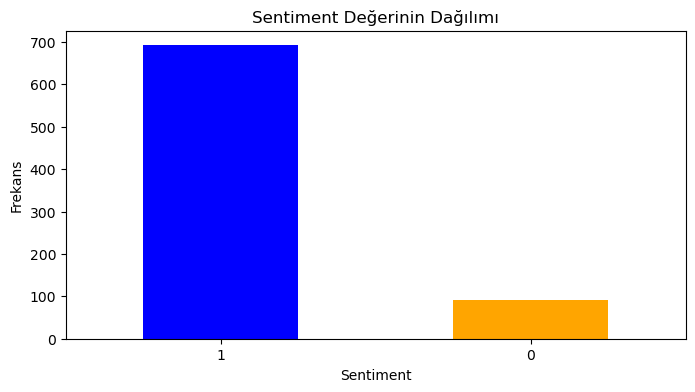

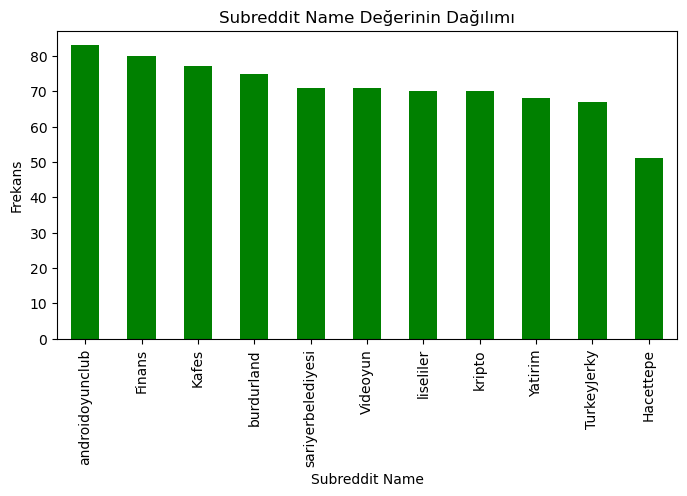

In [4]:
pandas_df = spark_df.toPandas()
sentiment_distribution = pandas_df['sentiment'].value_counts()

plt.figure(figsize=(8, 4))
sentiment_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Sentiment Değerinin Dağılımı')
plt.xlabel('Sentiment')
plt.ylabel('Frekans')
plt.xticks(rotation=0)
plt.show()

subreddit_distribution = pandas_df['subreddit_name'].value_counts()

plt.figure(figsize=(8, 4))
subreddit_distribution.plot(kind='bar', color='green')
plt.title('Subreddit Name Değerinin Dağılımı')
plt.xlabel('Subreddit Name')
plt.ylabel('Frekans')
plt.xticks(rotation=90)
plt.show()

In [5]:
tokenizer = Tokenizer(inputCol="selftext", outputCol="words")

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")

idf = IDF(inputCol="rawFeatures", outputCol="features")


In [6]:
indexer = StringIndexer(inputCol="subreddit_name", outputCol="label")

## Logistic Regresion

In [7]:
lr = LogisticRegression(maxIter=10, regParam=0.001)

In [8]:
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, indexer, lr])

In [9]:
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=1234)
model = pipeline.fit(train_data)

predictions = model.transform(test_data)

predictions.select("selftext", "subreddit_name", "prediction").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------+
|selftext                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |subreddit_name   |prediction|
+-----------------

In [10]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Model doğruluğu: {accuracy}")

Model doğruluğu: 0.5151515151515151


## Random forest classifier

In [11]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, indexer, rf])

train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=1234)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

predictions.select("selftext", "subreddit_name", "prediction").show(truncate=False)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"RandomForestClassifier modelinin doğruluğu: {accuracy}")

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------+
|selftext                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |subreddit_name   |prediction|
+-----------------

## Decision Tree Algorithm

In [17]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

pipeline_dt = Pipeline(stages=[tokenizer, remover, hashingTF, idf, indexer, dt])

train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=1234)

model_dt = pipeline_dt.fit(train_data)

predictions_dt = model_dt.transform(test_data)

predictions_dt.select("selftext", "subreddit_name", "prediction").show(truncate=False)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator.evaluate(predictions_dt)

print(f"DecisionTreeClassifier modelinin doğruluğu: {accuracy_dt}")

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------+
|selftext                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |subreddit_name   |prediction|
+-----------------